In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import shap
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import r2_score as R2, mean_absolute_error as MAE, mean_squared_error as MSE, accuracy_score as acs

In [2]:
pwd = os.getcwd()

In [3]:
df = pd.read_csv(pwd+"/Encoded_dataset/df_encoded_FF.csv",low_memory=False)
df.shape

(26440, 30)

In [4]:
df.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure,JV_default_FF
0,0.670488,0,0,0.671194,0.654624,58.0,0.660002,0,0,1,...,0.662479,0.657723,0,0.666488,34.0,0.658443,0.664248,100.0,0.660494,0.630
1,0.670488,0,0,0.671194,0.685883,60.0,0.660002,1,0,0,...,0.662479,0.626171,0,0.650468,30.0,0.658443,0.664248,150.0,0.660494,0.640
2,0.670488,0,0,0.671194,0.628983,50.0,0.652631,0,0,1,...,0.662479,0.657723,0,0.666488,15.0,0.658443,0.664248,120.0,0.660494,0.784
3,0.670488,0,0,0.671194,0.683229,25.0,0.677976,0,0,1,...,0.675949,0.671190,0,0.692654,180.0,0.658443,0.664248,75.0,0.660494,0.745
4,0.653282,0,0,0.652112,0.645665,205.0,0.660002,0,0,1,...,0.675949,0.654654,0,0.658165,150.0,0.658443,0.657487,76.0,0.660494,0.686


In [5]:
# Select feature list and target variable
X = df.iloc[:,:-1]
y = df['JV_default_FF']  
print(f"Shape of X: {str(X.shape)}\nShape of y: {str(y.shape)}")

Shape of X: (26440, 29)
Shape of y: (26440,)


#### Loading new sample cell dataframe for prediction

In [6]:
new_X = pd.read_csv(pwd+"/Cell_to_predict/cell_encoded_FF.csv")
new_X

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,0.653282,0,0,0.652112,0.65017,40.0,0.652631,0,0,1,...,1,0.65863,0.65863,0,0.624823,220.0,0.658443,0.664248,100.0,0.660494


## Scaling Features

In [7]:
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
new_X[new_X.columns] = scaler.transform(new_X[new_X.columns])

In [8]:
X.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,1.000000,0.0,0.0,0.858303,0.513445,0.00230,0.578755,0.0,0.0,1.0,...,1.0,0.498418,0.524241,0.0,0.562352,0.00132,0.703433,0.547569,0.000817,0.746466
1,1.000000,0.0,0.0,0.858303,0.648614,0.00238,0.578755,1.0,0.0,0.0,...,0.0,0.498418,0.384187,0.0,0.507124,0.00116,0.703433,0.547569,0.001233,0.746466
2,1.000000,0.0,0.0,0.858303,0.402567,0.00198,0.534299,0.0,0.0,1.0,...,1.0,0.498418,0.524241,0.0,0.562352,0.00056,0.703433,0.547569,0.000983,0.746466
3,1.000000,0.0,0.0,0.858303,0.637137,0.00098,0.687155,0.0,0.0,1.0,...,1.0,0.570764,0.584020,0.0,0.652558,0.00716,0.703433,0.547569,0.000608,0.746466
4,0.898426,0.0,0.0,0.726436,0.474705,0.00818,0.578755,0.0,0.0,1.0,...,1.0,0.570764,0.510616,0.0,0.533659,0.00596,0.703433,0.503443,0.000617,0.746466


In [9]:
new_X.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,0.898426,0.0,0.0,0.726436,0.494185,0.00158,0.534299,0.0,0.0,1.0,...,1.0,0.477743,0.528266,0.0,0.418717,0.00876,0.703433,0.547569,0.000817,0.746466


In [10]:
X_train, X_test, y_train, y_test = TTS(X,y,test_size=0.3,random_state=42)
print(f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

X_train: (18508, 29) 
X_test: (7932, 29) 
y_train: (18508,) 
y_test: (7932,)


In [11]:
def parity_plot(predicted_train, predicted_test, y1=y_train, y2=y_test):
    """ Plots the Predicted FF vs Actual FF"""
    plt.style.use('default')
    plt.figure(figsize=(10,4))
    # Plot for Training Dataset
    plt.subplot(1,2,1)
    plt.scatter(y1, predicted_train, c='r', label='Train data', edgecolors=(0, 0, 0), marker="o")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual FF')
    plt.ylabel('Predicted FF')
    plt.title("Training DataSet")
    # Plot for Test Dataset
    plt.subplot(1,2,2)
    plt.scatter(y2, predicted_test, c='b', label='Test data', edgecolors=(0, 0, 0), marker="o")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual FF')
    plt.title("Test DataSet")
    
    #plt.savefig(pwd+'/Parity_plots/parity_plot_Voc.png', dpi=350)
    return plt.show()

def get_evaluation(train_pred_y,test_pred_y):
    """ Gets ML model metrics Mean Square Error, Root Mean Square Error, Mean Absolute Error and R2 Score """
    # Metrics for Training Dataset
    mse_train = MSE(y_train, train_pred_y)
    rmse_train = np.sqrt(mse_train)
    mae_train = MAE(y_train, train_pred_y)
    r2_train = R2(y_train,train_pred_y)
   
    # Metrics for Test Dataset
    mse_test = MSE(y_test, test_pred_y)
    rmse_test = np.sqrt(mse_test)
    mae_test = MAE(y_test, test_pred_y)
    r2_test = R2(y_test,test_pred_y)

    eval_df = pd.DataFrame({
        "Metrics":["Mean Square Error (MSE)","Root Mean Square Error (RMSE)","Mean Absolute Error (MAE)","R2_Score"],
        "Training Data": [mse_train,rmse_train,mae_train,r2_train],
        "Test Data": [mse_test,rmse_test,mae_test,r2_test]
    })
    return eval_df

def model_builder(model_name):
    model_name.fit(X_train, y_train)
    y_pred_train = model_name.predict(X_train)
    y_pred_test = model_name.predict(X_test)
    parity_plot(y_pred_train,y_pred_test)
    eval_df = get_evaluation(y_pred_train,y_pred_test)
    return eval_df

### ExtraTreesRegressor Model

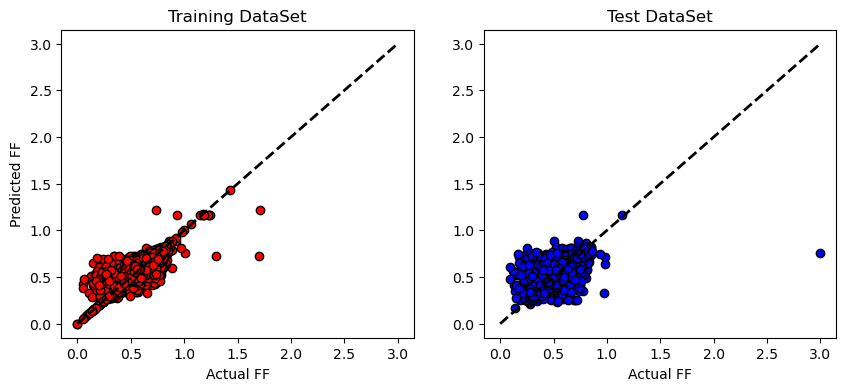

,Metrics,Training Data,Test Data
0,Mean Square Error (MSE),0.002369,0.007581
1,Root Mean Square Error (RMSE),0.048672,0.087071
2,Mean Absolute Error (MAE),0.023781,0.053806
3,R2_Score,0.839823,0.485885


In [12]:
et = ExtraTreesRegressor(random_state=42)
et_metrics = model_builder(et)
et_metrics

### Hyper Parameter Tuning

In [13]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 30, 40],
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the search object
search = GridSearchCV(et, param_grid, cv=5, n_jobs=-1)

# Fit the search object to the training data
search.fit(X_train, y_train)

# Print the best parameters
print(f'Best parameters: {search.best_params_}')

# Get the best model
best_et = search.best_estimator_

/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 40}


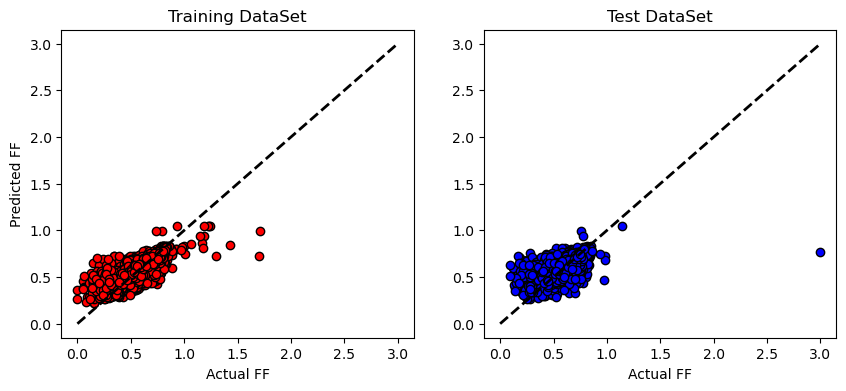

,Metrics,Training Data,Test Data
0,Mean Square Error (MSE),0.003555,0.007153
1,Root Mean Square Error (RMSE),0.059622,0.084574
2,Mean Absolute Error (MAE),0.037761,0.054208
3,R2_Score,0.759635,0.514951


In [14]:
best_et_metrics = model_builder(best_et)
best_et_metrics

In [15]:
pickle.dump(best_et, open(pwd + '/Hp_tuned_best_models/best_et_FF.sav', 'wb'))

In [16]:
# Loading best model after hyperparameter tuning
best_et = pickle.load(open(pwd+'/Hp_tuned_best_models/best_et_FF.sav','rb'))

In [17]:
predicted_FF_et = best_et.predict(new_X)
predicted_FF_et

array([0.53907236])

### RandomForestRegressor Model

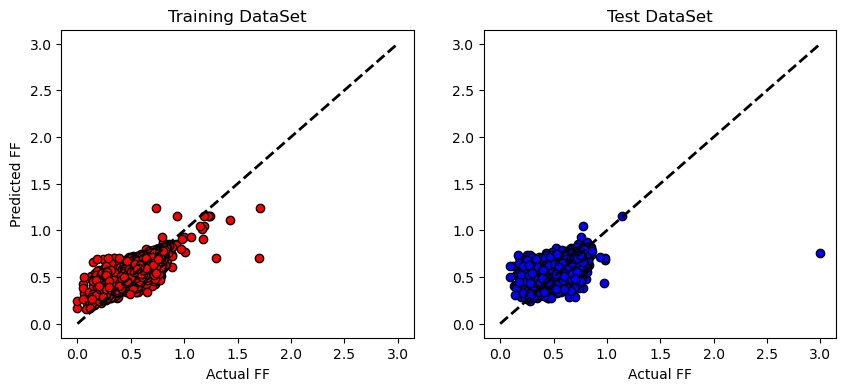

,Metrics,Training Data,Test Data
0,Mean Square Error (MSE),0.002839,0.007192
1,Root Mean Square Error (RMSE),0.053281,0.084808
2,Mean Absolute Error (MAE),0.032569,0.053560
3,R2_Score,0.808044,0.512260


In [18]:
rf = RandomForestRegressor(random_state=42)
rf_metrics = model_builder(rf)
rf_metrics

### Hyper Parameter Tuning

In [19]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] # Warning - 'max_features' 'auto' is deprecated. 
}

# Define the search object
search = RandomizedSearchCV(rf, param_grid, cv=5, n_iter=50, n_jobs=-1, random_state=42)

# Fit the search object to the training data
search.fit(X_train, y_train)

# Print the best parameters
print(f'Best parameters: {search.best_params_}')

# Get the best model
best_rf = search.best_estimator_

/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


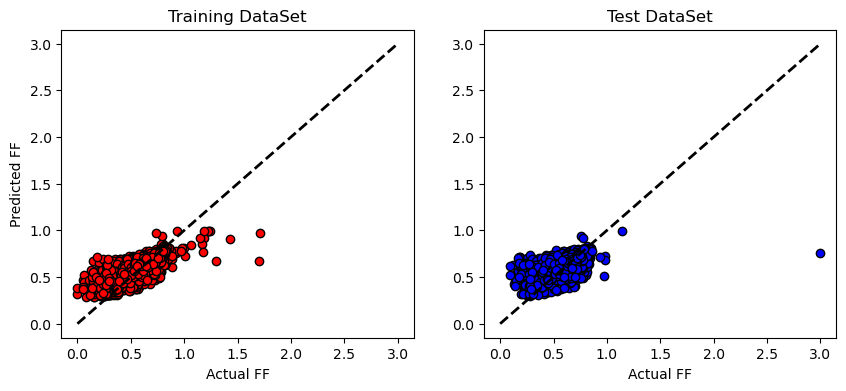

,Metrics,Training Data,Test Data
0,Mean Square Error (MSE),0.004198,0.007178
1,Root Mean Square Error (RMSE),0.064792,0.084725
2,Mean Absolute Error (MAE),0.042962,0.055346
3,R2_Score,0.716148,0.513218


In [20]:
best_rf_metrics = model_builder(best_rf)
best_rf_metrics

In [21]:
pickle.dump(best_rf, open(pwd + '/Hp_tuned_best_models/best_rf_FF.sav', 'wb'))

In [12]:
# Loading best model after hyperparameter tuning
best_rf = pickle.load(open(pwd+'/Hp_tuned_best_models/best_rf_FF.sav','rb'))

In [23]:
predicted_FF_rf = best_rf.predict(new_X)
predicted_FF_rf

array([0.51544317])

#### SHAP Analysis

In [13]:
X1000 = shap.sample(X, 1000)
shap_explainer = shap.TreeExplainer(best_rf, X1000)
shap_values = shap_explainer(X1000)

 99%|===================| 994/1000 [01:17<00:00]        

In [18]:
# Get non-categorical features
X_num = ['ETL_thickness', 'Perovskite_thickness', 'Perovskite_band_gap', 'HTL_thickness_list', 'Backcontact_thickness_list']
X_bool = [ 'Cell_flexible', 'Cell_semitransparent', 'Perovskite_dimension_2D', 'Perovskite_dimension_2D3D_mixture', 'Perovskite_dimension_3D', 
           'Perovskite_dimension_3D_with_2D_capping_layer', 'Perovskite_composition_perovskite_ABC3_structure', 'Perovskite_composition_inorganic', 
           'Perovskite_band_gap_graded', 'Perovskite_deposition_quenching_induced_crystallisation', 'Perovskite_deposition_solvent_annealing']

In [19]:
indices_num = []
indices_bool = []
for i,f in enumerate(shap_values.feature_names):
    if f in X_num:
        indices_num.append(i)
    if f in X_bool:
        indices_bool.append(i)
print(indices_num)
print("Number of numerical features: ",len(indices_num))
print(indices_bool)
print("Number of boolean features: ",len(indices_bool))

[5, 13, 15, 24, 27]
Number of numerical features:  5
[1, 2, 7, 8, 9, 10, 11, 14, 16, 19, 22]
Number of boolean features:  11


In [26]:
plt.gcf()
shap.plots.beeswarm(shap_values[:, indices_num], max_display=15,show=False)
plt.savefig("shap_ff_rf_num.png", dpi=600, bbox_inches='tight')
plt.close()

In [23]:
plt.gcf()
shap.plots.beeswarm(shap_values[:, indices_bool], max_display=15,show=False)
plt.savefig("shap_ff_rf_bool.png", dpi=600, bbox_inches='tight')
plt.close()